# Panichello & Buschmann, 2021

Let's get the fitted representations and make:
1. The sexy subspace plot
2. Calucate the correlation between subspaces and the angle

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
from jax.example_libraries import optimizers
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib


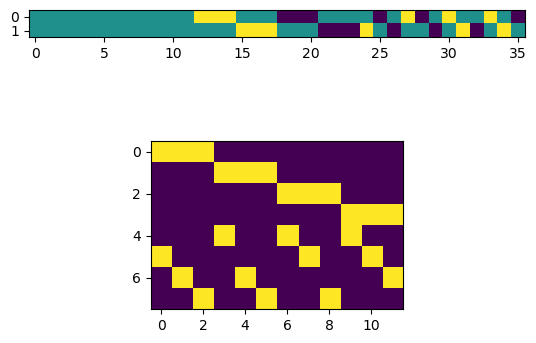

In [6]:
biased = 1

# Num of stim
Q = 4
thetas = [np.pi*2/Q*i for i in range(Q)]

targets = np.zeros([2, 3*Q**2])
regressors = np.zeros([2*Q, Q**2])
counter = 0
for q in range(Q):
    targets[0,Q**2+q*Q:Q**2+Q+q*Q] = np.cos(thetas[q])
    targets[1,Q**2+q*Q:Q**2+Q+q*Q] = np.sin(thetas[q])

    targets[0,2*Q**2+q:3*Q**2:Q] = np.cos(thetas[q])
    targets[1,2*Q**2+q:3*Q**2:Q] = np.sin(thetas[q])


    for qp in range(Q):
        regressors[q, counter] = 1
        regressors[qp+Q,counter] = 1
        counter+=1


if biased == 1:
    remove_indices = []

    for trial in range(Q*Q):
        first_target = np.where(regressors[:Q, trial]==1)[0]
        second_target = np.where(regressors[Q:, trial]==1)[0]
        if first_target == second_target:
            remove_indices.append(trial)

    remove_timepoints = remove_indices + [i + Q*Q for i in remove_indices] + [i + 2*Q*Q for i in remove_indices]

    regressors = np.delete(regressors, remove_indices, axis = 1)
    targets = np.delete(targets, remove_timepoints, axis = 1)
    num_trials = Q*Q - len(remove_indices)
    
    g = np.load('./data/P&B_Biased.npy', allow_pickle = True)[()]
else:
    g = np.load('./data/P&B_Unbiased.npy', allow_pickle = True)[()]

N = g.shape[0]
plt.subplot(2,1,1)
plt.imshow(targets)

plt.subplot(2,1,2)
plt.imshow(regressors)

Proportion negative: 1.87852365343133e-05


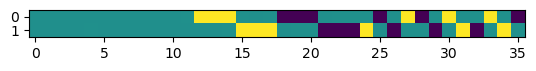

In [7]:
# First check that the neural representation is positive and fits the data
negative_activity = g[g<0]
print(f'Proportion negative: {np.linalg.norm(negative_activity)/np.linalg.norm(g)}')

def generate_R(g, targets):
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    Q = jnp.matmul(g_bias, g_bias.T)
    R = jnp.matmul(g_bias, targets.T)
    P = jnp.matmul(jnp.linalg.inv(Q + 0.0001*jnp.eye(g.shape[0]+1)), R)
    return P

R = generate_R(g, targets)

preds = R[:-1,:].T@g + R[-1,:][:,None]

plt.imshow(preds)

Propotion of Activity Kept: 0.9968421459197998
Propotion of Activity Kept: 0.9949382543563843
Angles: [83.53724077 85.00206529]
Correlation between subspaces: 0.09491489243676855
Subspace Ration: 1.0025362840630336


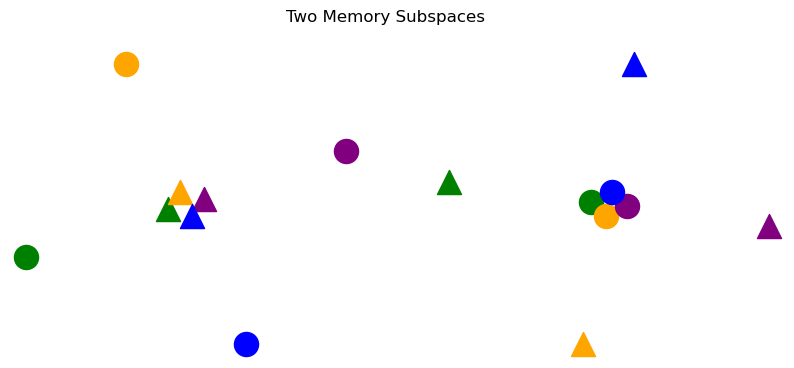

In [8]:
g_delay = g[:,:regressors.shape[1]]

# PC extracting function
def get_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:2]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])

# We extract 3 to use in the next section, only two are used here
PCs = np.zeros([N, 2, 2])
for order in range(2):
    diff_vec = []
    for q in range(Q):
        q_not_in_other_rank = np.where(regressors[(1-order)*Q+q,:] != 1)[0]
        q_in_this_rank = np.where(regressors[Q*order+q,:] == 1)[0]
        for qp in range(Q):
            if qp != q:
                qp_not_in_other_rank = np.where(regressors[(1-order)*4+qp,:] != 1)[0]
                qp_in_this_rank = np.where(regressors[Q*order+qp,:] == 1)[0]

                other_rank_not_q_or_qp = np.intersect1d(q_not_in_other_rank, qp_not_in_other_rank)
                q_this_rank_avg_ind = np.intersect1d(q_in_this_rank, other_rank_not_q_or_qp)
                qp_this_rank_avg_ind = np.intersect1d(qp_in_this_rank, other_rank_not_q_or_qp)

                diff_vec.append(np.mean(g_delay[:,q_this_rank_avg_ind],axis=1) - np.mean(g_delay[:,qp_this_rank_avg_ind], axis = 1))
    diff_vec = np.stack(diff_vec).T
    PCs[:,order,:] = get_PCs(diff_vec)

# Regenerate the encoding of each colour in each position
extracted_encodings = np.zeros([Q, N, 2, Q])
for order in range(2):
    for base in range(Q):
        Base_q_not_in_other_rank = np.where(regressors[(1-order)*Q+base,:] != 1)[0]
        Base_q_in_this_rank = np.where(regressors[Q*order+base,:] == 1)[0]
        for q in range(Q):
            if q != base:
                q_not_in_other_rank = np.where(regressors[(1-order)*Q+q,:] != 1)[0]
                q_in_this_rank = np.where(regressors[Q*order+q,:] == 1)[0]
        
                other_rank_not_q_or_base_q = np.intersect1d(q_not_in_other_rank, Base_q_not_in_other_rank)
                q_this_rank_avg_ind = np.intersect1d(q_in_this_rank, other_rank_not_q_or_base_q)
                Base_q_this_rank_avg_ind = np.intersect1d(Base_q_in_this_rank, other_rank_not_q_or_base_q)
        
                extracted_encodings[base,:,order,q] = np.mean(g_delay[:,q_this_rank_avg_ind],axis=1) - np.mean(g_delay[:,Base_q_this_rank_avg_ind], axis = 1)

# Now really that was a set of difference vectors, let's make each order mean zero
for order in range(2):
    for base in range(Q):
        extracted_encodings[base,:,order,:] = extracted_encodings[base,:,order,:] - np.mean(extracted_encodings[base,:,order,:], axis = 1)[:,None]

# And average over base
extracted_encodings = np.mean(extracted_encodings, axis = 0)

# Now we project the encodings into the PC space
subspace_coefficients = np.zeros([2, 2, Q, 2]) # num subspaces, by which points project, by num points, by dim subspace
for subspace in range(2):
    for encoding_order in range(2):
        for q in range(Q):
            subspace_coefficients[subspace, encoding_order, q, :] = PCs[:,subspace,:2].T@extracted_encodings[:,encoding_order,q]

# Now do simple 2D plots
plt.figure(figsize = (10, 4))
markers = ['o', '^']
colours = ['green', 'orange', 'purple', 'blue']
for order in range(2):
    plt.subplot(1,2,1+order)
    ax = plt.gca()
    ax.axis('off')
    for encoding_order in range(2):
        for q in range(Q):
            plt.scatter(subspace_coefficients[order, encoding_order,q,0], subspace_coefficients[order, encoding_order,q,1], c = colours[q], s = 300, marker = markers[encoding_order])
plt.suptitle('Two Memory Subspaces')

U, S, V = np.linalg.svd(PCs[:,0,:].T@PCs[:,1,:])
angles = np.arccos(S)/np.pi*180
print(f'Angles: {angles}')

# Now let's try to calculate their correlation measure.
rho = 0
for l in range(2):
    for q in range(Q):
        rho += np.corrcoef(extracted_encodings[:,l,q], extracted_encodings[:,1-l,q])[0,1]
rho = rho/(2*Q)
print(f'Correlation between subspaces: {rho}')

subspace_sizes = np.array([np.linalg.norm(extracted_encodings[:,i,:]) for i in range(2)])
subspace_ratio = subspace_sizes[0]/subspace_sizes[1]
print(f'Subspace Ration: {subspace_ratio}')

Propotion of Activity Kept: (0.5100451329649097-1.642695987739212e-34j)
Propotion of Activity Kept: 0.9999999725076935
Propotion of Activity Kept: 0.9999999410250471


Text(0.5, 0.92, 'Cosine of Angle Between Planes: 0.000')

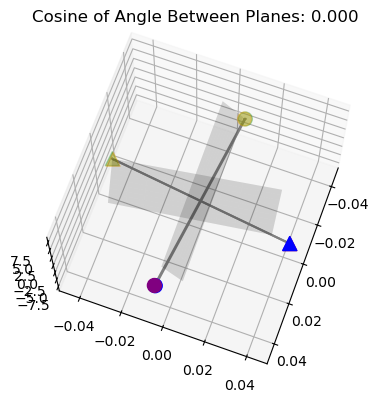

In [277]:
def plane_plotter(normal, points):
    center = points.mean(axis=1)
    d = center.dot(normal)
    X = np.arange(points[0,:].min(), points[0,:].max(), (points[0,:].max() - points[0,:].min()) / 10)
    Y = np.arange(points[1,:].min(), points[1,:].max(), (points[1,:].max() - points[1,:].min()) / 10)
    xx, yy = np.meshgrid(X, Y)
    z = (-normal[0] * xx - normal[1] * yy + d) * 1. / normal[2]
    return xx, yy, z, 

colours = ['green', 'orange', 'purple', 'blue']

# Let's get the 3D PCs of the pre subspace
PCs_3D_pre = get_PCs(np.reshape(extracted_encodings, [N, 2*Q]), num_eigs = 3)
Encodings_3D_pre = np.einsum('ij,ikl->jkl', PCs_3D_pre, extracted_encodings)

# Get the two plane vectors and normals
plane_vectors_1 = get_PCs(Encodings_3D_pre[:,0,:])
plane_vectors_2 = get_PCs(Encodings_3D_pre[:,1,:])
normal_1 = np.cross(plane_vectors_1[:,0], plane_vectors_1[:,1])
normal_2 = np.cross(plane_vectors_2[:,0], plane_vectors_2[:,1])

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121, projection='3d')
xx, yy, z = plane_plotter(normal_1, Encodings_3D_pre[:,0,:])
ax.plot_surface(xx, yy, z, alpha=0.15, color='k', linewidth=0)

xx, yy, z = plane_plotter(normal_2, Encodings_3D_pre[:,1,:])
ax.plot_surface(xx, yy, z, alpha=0.15, color='k', linewidth=0)

ax.scatter(Encodings_3D_pre[0,0,:], Encodings_3D_pre[1,0,:], Encodings_3D_pre[2,0,:], c = colours, marker = 'o', s = 100)
ax.scatter(Encodings_3D_pre[0,1,:], Encodings_3D_pre[1,1,:], Encodings_3D_pre[2,1,:], c = colours, marker = '^', s = 100)

for plot in range(2):
    for q in range(4):
        ax.plot([Encodings_3D_pre[0,plot,q], Encodings_3D_pre[0,plot,np.mod(q+1,4)]], [Encodings_3D_pre[1,plot,q], Encodings_3D_pre[1,plot,np.mod(q+1,4)]], [Encodings_3D_pre[2,plot,q], Encodings_3D_pre[2,plot,np.mod(q+1,4)]], 'gray')
ax.view_init(elev=70, azim=20)
#ax.set_xticks([-0.2, 0, 0.2])
#ax.set_yticks([-0.2, 0, 0.2])
#ax.set_zticks([-0.2, 0, 0.2])

ax.set_title(f"Cosine of Angle Between Planes: {np.dot(normal_1, normal_2):.3f}")

In [145]:
Encodings_3D_pre.shape

(3, 2, 4)

In [99]:


eigvecs_plane_1 = plane_extract(pre_act_3D_subspace[:,:Q])
eigvecs_plane_2 = plane_extract(pre_act_3D_subspace[:,Q:])

normal_1 = np.cross(eigvecs_plane_1[:,0], eigvecs_plane_1[:,1])
normal_2 = np.cross(eigvecs_plane_2[:,0], eigvecs_plane_2[:,1])

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121, projection='3d')
xx, yy, z = plane_plotter(normal_1, pre_act_3D_subspace[:,:Q])
ax.plot_surface(xx, yy, z, alpha=0.15, color='k', linewidth=0)

xx, yy, z = plane_plotter(normal_2, pre_act_3D_subspace[:,Q:])
ax.plot_surface(xx, yy, z, alpha=0.15, color='k', linewidth=0)

ax.scatter(pre_act_3D_subspace[0,:Q], pre_act_3D_subspace[1,:Q], pre_act_3D_subspace[2,:Q], c = colours, marker = 'o', s = 100)
ax.scatter(pre_act_3D_subspace[0,Q:], pre_act_3D_subspace[1,Q:], pre_act_3D_subspace[2,Q:], c = colours, marker = '^', s = 100)

for plot in range(2):
    for q in range(4):
        ax.plot([pre_act_3D_subspace[0,q+plot*4], pre_act_3D_subspace[0,np.mod(q+1,4)+plot*4]], [pre_act_3D_subspace[1,q+plot*4], pre_act_3D_subspace[1,np.mod(q+1,4)+plot*4]], [pre_act_3D_subspace[2,q+plot*4], pre_act_3D_subspace[2,np.mod(q+1,4)+plot*4]], 'gray')
ax.view_init(elev=20., azim=150)
ax.set_xticks([-0.2, 0, 0.2])
ax.set_yticks([-0.2, 0, 0.2])
ax.set_zticks([-0.2, 0, 0.2])

ax.set_title(f"Cosine of Angle Between Planes: {np.dot(normal_1, normal_2):.3f}")

eigvecs_plane_3 = plane_extract(post_act_3D_subspace[:,:Q])
eigvecs_plane_4 = plane_extract(post_act_3D_subspace[:,Q:])

normal_3 = np.cross(eigvecs_plane_3[:,0], eigvecs_plane_3[:,1])
normal_4 = np.cross(eigvecs_plane_4[:,0], eigvecs_plane_4[:,1])

ax = fig.add_subplot(122, projection='3d')
xx, yy, z = plane_plotter(normal_3, post_act_3D_subspace[:,:Q])
ax.plot_surface(xx, yy, z, alpha=0.15, color='k', linewidth=0)

xx, yy, z = plane_plotter(normal_4, post_act_3D_subspace[:,Q:])
ax.plot_surface(xx, yy, z, alpha=0.15, color='k', linewidth=0)

ax.scatter(post_act_3D_subspace[0,:Q], post_act_3D_subspace[1,:Q], post_act_3D_subspace[2,:Q], c = colours, marker = 'o', s = 100)
ax.scatter(post_act_3D_subspace[0,Q:], post_act_3D_subspace[1,Q:], post_act_3D_subspace[2,Q:], c = colours, marker = '^', s = 100)
for plot in range(2):
    for q in range(4):
        ax.plot([post_act_3D_subspace[0,q+plot*4], post_act_3D_subspace[0,np.mod(q+1,4)+plot*4]], [post_act_3D_subspace[1,q+plot*4], post_act_3D_subspace[1,np.mod(q+1,4)+plot*4]], [post_act_3D_subspace[2,q+plot*4], post_act_3D_subspace[2,np.mod(q+1,4)+plot*4]], 'gray')
ax.view_init(elev=-0., azim=30)
ax.set_title(f"Cosine of Angle Between Planes: {np.dot(normal_3, normal_4):.3f}")
ax.set_zlim([-0.0005, 0.0005])
demeaned_act =  pre_act_3D_subspace[0,:Q] - np.mean(pre_act_3D_subspace[:,:Q])
ax.set_xticks([-0.2, 0, 0.2])
ax.set_yticks([-0.2, 0, 0.2])
ax.set_zticks([-0.0005, 0, 0.0005])


(20, 2, 4)